classification is the problem of predicting whether something is one thing or the other  

In [2]:

import sklearn
from sklearn.datasets import make_circles

#make 1000 samples
n_samples = 1000

#create circles, X is feature , y is label 
X,y=make_circles(n_samples,
                noise=0.03,
                random_state=42)

print(f"first 5 samples of X: {X[:5]}")
print(f"first 5 samples of Y: {y[:5]}")

first 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of Y: [1 1 1 1 0]


In [3]:
#make dataframe of circle data 
import pandas as pd 
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

print(circles.head(10))

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0


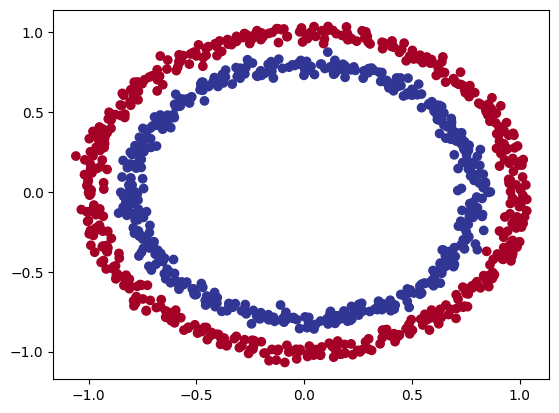

In [4]:
#visualization
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

The data we're woking with is often referred to a toy data set , a dataset which is small enough to experiment but still sizeable enough to practice the fundamentals 

In [5]:
#check input and output shapes 
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
#View the first example of features and labels
X_sample=X[0]
y_sample=y[0]

print(f"values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
shapes for one sample of X: (2,) and the same for y: ()


In [7]:
#1.2 Turn data into tensors and test splits
import torch
print(torch.__version__)

X=torch.from_numpy(X).type(torch.float)#converting it from array to tensor
y=torch.from_numpy(y).type(torch.float)

X[:5], y[:5]
X.dtype,y.dtype


2.6.0+cu126


(torch.float32, torch.float32)

In [8]:
#split data into training and test sets
from sklearn.model_selection import train_test_split #makes machine learning models easier

X_train, X_test, y_train, y_test=train_test_split(X,
                                                  y,
                                                  test_size=0.2,#takes 20% of data for test
                                                  random_state=42)#similar to random seed , but for scikit learn code

len(X_train),len(y_train),len(y_test),len(X_test)

(800, 800, 200, 200)

In [9]:
##building a model
import torch
from torch import nn

#make device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"

Subclass nn.Module, all models in pytorch , almost , subclass nn.Module
then we will create nn.linear layers capable of handling the shapes of our data
then define a forward method that does what forward pass or forward computation of the model does
then we instantiate an instance of our model class and send it to the target device 

In [10]:
#construction of a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #2. Create 2 nn.Linear layers to handle the shapes of our data
        self.layer1=nn.Linear(in_features=2,out_features=5)#in feature is 2 since shape of x , upscales to 5 features
        self.layer2=nn.Linear(in_features=5,out_features=1)#takes in 5 featres from previous layer and outputs a single feature(same shape as y)
    
    #defining a forward method that outlines the forward pass
    def forward(self,x):
        return self.layer2(self.layer1(x))#x->layer 1-> layer 2 -> output
    
    #instantiate an instance of the model class and send it to the target device

model0=CircleModelV0().to(device) 


In [11]:
#use of nn.sequential to replicate the model above, has another version of this where you use sequential in the above model
model0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1965, -0.2734],
                      [ 0.5451,  0.3344],
                      [ 0.0573,  0.0815],
                      [ 0.6460,  0.1490],
                      [ 0.4001, -0.2763]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0664, -0.5076, -0.3316, -0.3605, -0.3187], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1797,  0.1429,  0.2098, -0.3778, -0.3982]], device='cuda:0')),
             ('1.bias', tensor([0.3777], device='cuda:0'))])

In [12]:
#make prediction
with torch.inference_mode():
   utrpred=model0(X_test.to(device))
print(f"length of predictions: {len(utrpred)},shape: {utrpred.shape}")
print(f"length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{utrpred[:10]}")
print(f"First 10 labels:\n{y_test[:10]}")

length of predictions: 200,shape: torch.Size([200, 1])
length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.7056],
        [0.6435],
        [0.6295],
        [0.7282],
        [0.2501],
        [0.2152],
        [0.3409],
        [0.2396],
        [0.6456],
        [0.6352]], device='cuda:0')
First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
#setup a loss function and optimisizer 
#normal BCE loss requires for you to run sigmoid function on the inputs beforehand passing them in bceloss
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation function built in 

optimizer= torch.optim.SGD(params=model0.parameters(),
                           lr=0.1)

#calculate accuracy at the same time - out of 100 examples , what percentage our model gets right
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()#checks value by value and returns a boolean tensor for equality, sum gives number of correct predictions, item converts a singular tensor to a normal number
    acc=(correct/len(y_pred))*100
    return acc

In [14]:
#train model
#forward pass , then calculate loss , then optimizer zero grad , then loss backward(back propagation) , optimizer step(gradient descent)
model0.eval()
with torch.inference_mode():
    y_logits=model0(X_test.to(device))[:5]
y_logits

tensor([[0.7056],
        [0.6435],
        [0.6295],
        [0.7282],
        [0.2501]], device='cuda:0')

In [15]:
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs
#now we can pass this to torch.round function
torch.round(y_pred_probs)

y_preds=torch.round(y_pred_probs)

#in full(logit to pred prob to pred label)
y_pred_labels=torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

#check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [16]:
#building a training and testing loop
torch.cuda.manual_seed(69)

#set the number of epoch
epochs=1000

#put data to the target device
X_train, y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model0.train()

    #forward pass
    y_logits=model0(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))#turn logits to pred probs to pred labels

    #calculate loss/accuracy(accuracy is not necessary)
    loss = loss_fn(y_logits,
                   y_train)
    acc= accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    #optimizer
    optimizer.zero_grad()

    #back prop
    loss.backward()

    #optim step (gradient descent)
    optimizer.step()

    ##testing
    model0.eval()
    with torch.inference_mode():
        #forward pass
        test_logits=model0(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        #calculate test loss/accuracy
        test_loss=loss_fn(test_logits,
                          y_test)
        test_acc=accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
        #print output
        if epoch%100==0:
            print(f"epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | test loss: {test_loss:.5f},Test acc: {test_acc:.2f}%")

epoch: 0 | Loss: 0.72714, Acc:50.00% | test loss: 0.72583,Test acc: 50.00%
epoch: 100 | Loss: 0.69370, Acc:50.62% | test loss: 0.69757,Test acc: 48.00%
epoch: 200 | Loss: 0.69325, Acc:50.88% | test loss: 0.69639,Test acc: 46.00%
epoch: 300 | Loss: 0.69309, Acc:50.62% | test loss: 0.69575,Test acc: 45.50%
epoch: 400 | Loss: 0.69303, Acc:50.75% | test loss: 0.69537,Test acc: 47.50%
epoch: 500 | Loss: 0.69300, Acc:50.88% | test loss: 0.69513,Test acc: 47.00%
epoch: 600 | Loss: 0.69299, Acc:51.50% | test loss: 0.69498,Test acc: 47.00%
epoch: 700 | Loss: 0.69298, Acc:50.88% | test loss: 0.69488,Test acc: 46.50%
epoch: 800 | Loss: 0.69298, Acc:51.00% | test loss: 0.69481,Test acc: 46.00%
epoch: 900 | Loss: 0.69298, Acc:51.38% | test loss: 0.69477,Test acc: 46.00%


In [17]:
# make predictions and evaluate the model 

#model doesn't seem to learn anything , making some predictions now along with visualization 
#we are requesting a function from the internet
import requests
from pathlib import Path

#download helper functions from learn pytorch repo
if Path("helper_functions.py").is_file():
    print("downloading skipped")
else:
    print("downloading")
    request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary


downloading skipped


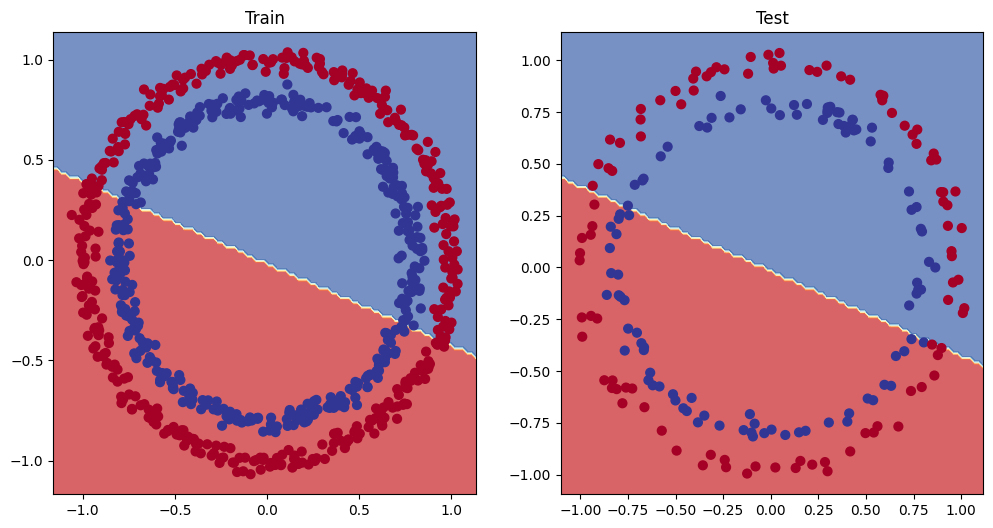

In [18]:
#plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(1,2,2)#rows , column , index
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)

In [19]:
#improving the model (from a model perspective)

#method 1 , add more layer , give the model more chances to learn 
#method 2 , add more hidden units , go from 5 to 10
#method 3 , give the model more chance to learn , so set the epoch higher
#method 4, changing the activation functions 
#method 5, change the learning rate
#method 6, change the loss function (not really necessary)

In [20]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=10)
        self.layer_2=nn.Linear(in_features=10, out_features=10)
        self.layer_3=nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x))) #onion shell ahh
    
model_1=CircleModelV1().to(device)
model_1
        

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
#create a loss functions
loss_fn= nn.BCEWithLogitsLoss()

#create an optimizer 
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.001)

#write a training and evaluation loop 
torch.manual_seed(69)
torch.cuda.manual_seed(69)

epochs=1000

#put data on the target device 
X_train, y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    #training
    model_1.train()
    #forward pass
    y_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    #calculate loss 
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    
    #optimizer zero grad
    optimizer.zero_grad()

    #backprop
    loss.backward()

    #optimizer step(gradient descent)
    optimizer.step()

    #testing
    model_1.eval()
    with torch.inference_mode():
        #forward pass
        test_logits=model_1(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        #calculate loss
        test_loss=loss_fn(test_logits,
                          y_test)
        test_acc=accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
    #print 
    if epoch%100==0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | test loss: {test_loss:.5f},Test acc: {test_acc:.2f}%")


epoch: 0 | Loss: 0.70300, Acc:46.62% | test loss: 0.69665,Test acc: 50.00%
epoch: 100 | Loss: 0.70233, Acc:46.88% | test loss: 0.69607,Test acc: 50.50%
epoch: 200 | Loss: 0.70173, Acc:47.12% | test loss: 0.69556,Test acc: 50.00%
epoch: 300 | Loss: 0.70119, Acc:47.38% | test loss: 0.69510,Test acc: 50.00%
epoch: 400 | Loss: 0.70070, Acc:47.88% | test loss: 0.69470,Test acc: 50.00%
epoch: 500 | Loss: 0.70026, Acc:48.12% | test loss: 0.69435,Test acc: 50.00%
epoch: 600 | Loss: 0.69986, Acc:48.38% | test loss: 0.69404,Test acc: 50.50%
epoch: 700 | Loss: 0.69950, Acc:48.00% | test loss: 0.69376,Test acc: 51.00%
epoch: 800 | Loss: 0.69917, Acc:48.12% | test loss: 0.69351,Test acc: 50.50%
epoch: 900 | Loss: 0.69886, Acc:48.25% | test loss: 0.69329,Test acc: 50.50%


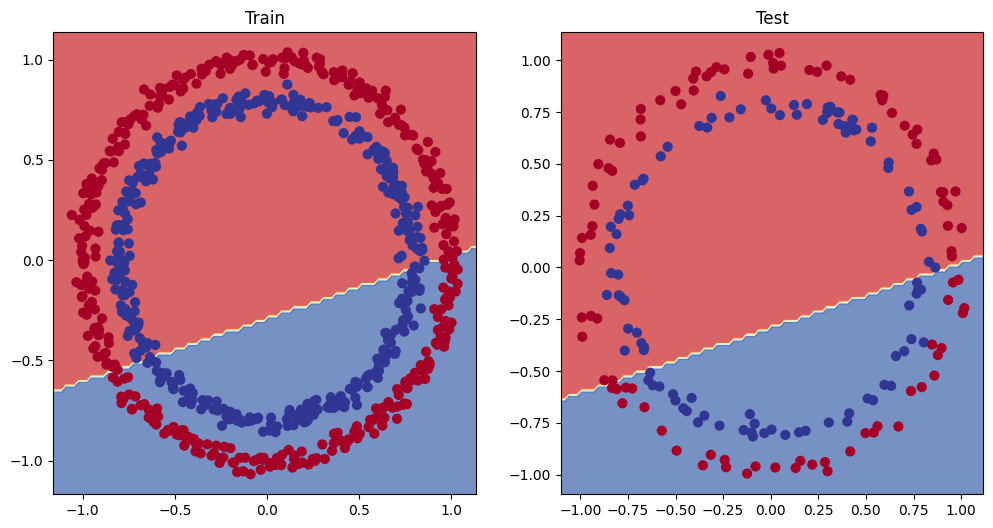

In [22]:
#plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)#rows , column , index
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

100


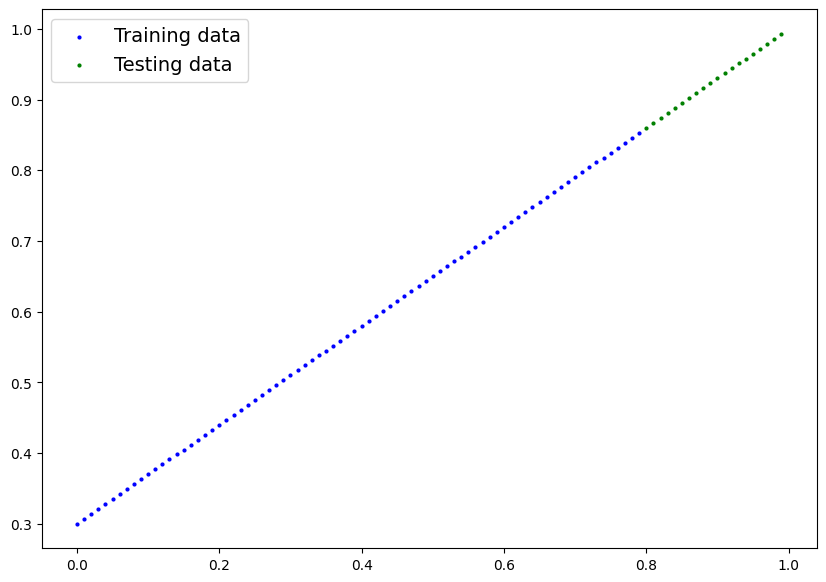

In [23]:
import torch
import matplotlib.pyplot as plt
#preparing data to see if the model can fit a straight line 

weight= 0.7
bias= 0.3
start=0
end=1
step=0.01

#create data
X_regression= torch.arange(start, end, step).unsqueeze(dim=1)
y_regression= weight*X_regression + bias #linear reg

#check the data 
print(len(X_regression))

#create train and test split
train_split=int(0.8*len(X_regression))
X_train_regression, y_train_regression= X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression= X_regression[train_split:], y_regression[train_split:]

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                    predictions=None)
plt.show()

In [24]:
#adjusting model1 to fit the straight line data 
#same arch as model one but using nn.sequential

model2= nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
#loss and optimizer
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model2.parameters(),
                          lr=0.1)

#train model 
torch.manual_seed(69)
torch.cuda.manual_seed(69)

epochs=1000

#put the data in target device
X_train_regression, y_train_regression=X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression=X_test_regression.to(device),y_test_regression.to(device)

for epoch in range(epochs):
    y_pred=model2(X_train_regression)
    loss=loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #testing 
    model2.eval()
    with torch.inference_mode():
        test_pred = model2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    #print 
    if epoch%100==0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}| test loss: {test_loss:.5f}")
        

epoch: 0 | Loss: 1.01970| test loss: 0.82519
epoch: 100 | Loss: 0.06358| test loss: 0.21205
epoch: 200 | Loss: 0.07935| test loss: 0.17758
epoch: 300 | Loss: 0.04924| test loss: 0.16646
epoch: 400 | Loss: 0.05724| test loss: 0.15268
epoch: 500 | Loss: 0.08374| test loss: 0.12828
epoch: 600 | Loss: 0.07433| test loss: 0.13728
epoch: 700 | Loss: 0.05192| test loss: 0.14310
epoch: 800 | Loss: 0.06578| test loss: 0.12066
epoch: 900 | Loss: 0.06096| test loss: 0.08705


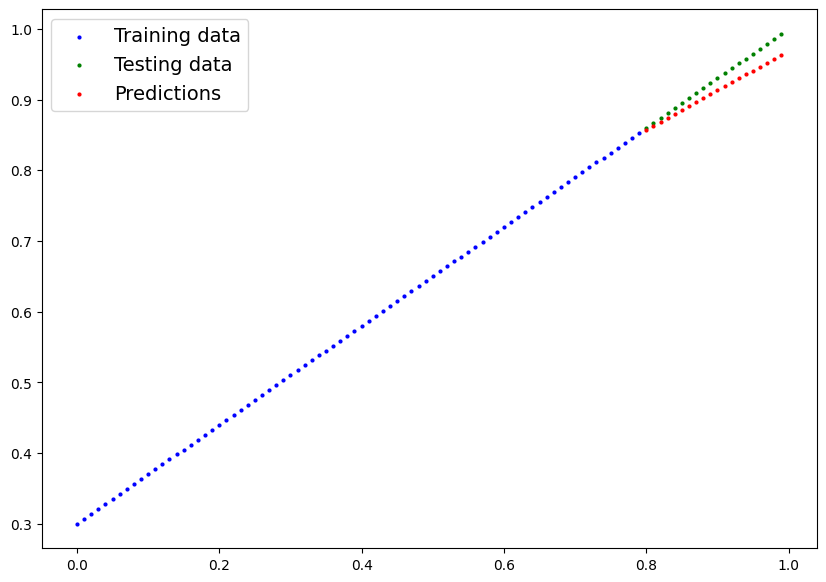

In [26]:
#turn on eval 
model2.eval()

with torch.inference_mode():
    y_preds=model2(X_test_regression)

#plot
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                    predictions=y_preds.cpu())

plt.show()

the missing piece: non-linearity 

we will give the model ability to deal with linear and non-linear values

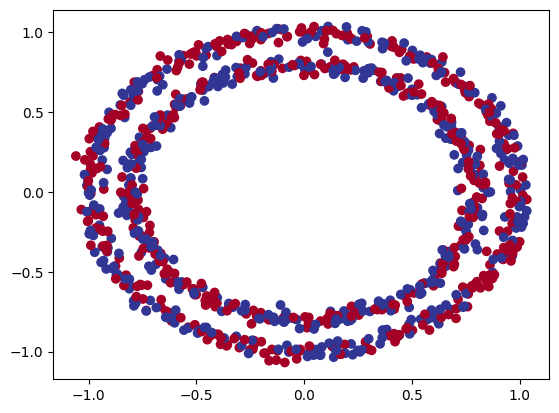

In [27]:
#recreating non-linear data (red and blue circles)

#make and plot data
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

n_samples=1000

x,y=make_circles(n_samples,
                 noise=0.03,
                 random_state=69)

plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [28]:
#convert data to tensors and then to train and test splits 
import torch 
from sklearn.model_selection import train_test_split

#turn data into tensors 
X= torch.from_numpy(x).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

#splits into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=69)

#build model with non-linearity
from torch import nn 
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2,
                              out_features=10)
        self.layer2=nn.Linear(in_features=10,
                              out_features=10)
        self.layer3=nn.Linear(in_features=10,
                              out_features=1)
        self.relu=nn.ReLU()#a non linear activation function

    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
model3=CircleModelV2().to(device)
#setup loss and optim 
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model3.parameters(),
                          lr=0.1)

#training a model with non-Linearity 
torch.manual_seed(69)
torch.cuda.manual_seed(69)

X_train, y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

# loop through data 
epochs = 1500

for epoch in range(epochs):
    model3.train()

    #forward pass
    y_logits= model3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    #calculate loss
    loss= loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Testing
    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
    #print
    if epoch%100==0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | test loss: {test_loss:.5f},Test acc: {test_acc:.2f}%")

epoch: 0 | Loss: 0.70067, Acc:49.25% | test loss: 0.69134,Test acc: 53.00%
epoch: 100 | Loss: 0.68942, Acc:52.62% | test loss: 0.69274,Test acc: 47.50%
epoch: 200 | Loss: 0.68735, Acc:53.87% | test loss: 0.69177,Test acc: 48.50%
epoch: 300 | Loss: 0.68434, Acc:55.00% | test loss: 0.68988,Test acc: 50.50%
epoch: 400 | Loss: 0.67995, Acc:57.12% | test loss: 0.68703,Test acc: 50.00%
epoch: 500 | Loss: 0.67391, Acc:57.12% | test loss: 0.68338,Test acc: 49.50%
epoch: 600 | Loss: 0.66495, Acc:59.88% | test loss: 0.67760,Test acc: 50.00%
epoch: 700 | Loss: 0.65045, Acc:65.38% | test loss: 0.66719,Test acc: 57.50%
epoch: 800 | Loss: 0.62535, Acc:71.88% | test loss: 0.64462,Test acc: 64.00%
epoch: 900 | Loss: 0.57859, Acc:85.25% | test loss: 0.59767,Test acc: 81.00%
epoch: 1000 | Loss: 0.49558, Acc:94.75% | test loss: 0.51172,Test acc: 94.50%
epoch: 1100 | Loss: 0.37785, Acc:98.12% | test loss: 0.39255,Test acc: 99.50%
epoch: 1200 | Loss: 0.25461, Acc:99.25% | test loss: 0.26419,Test acc: 99.50

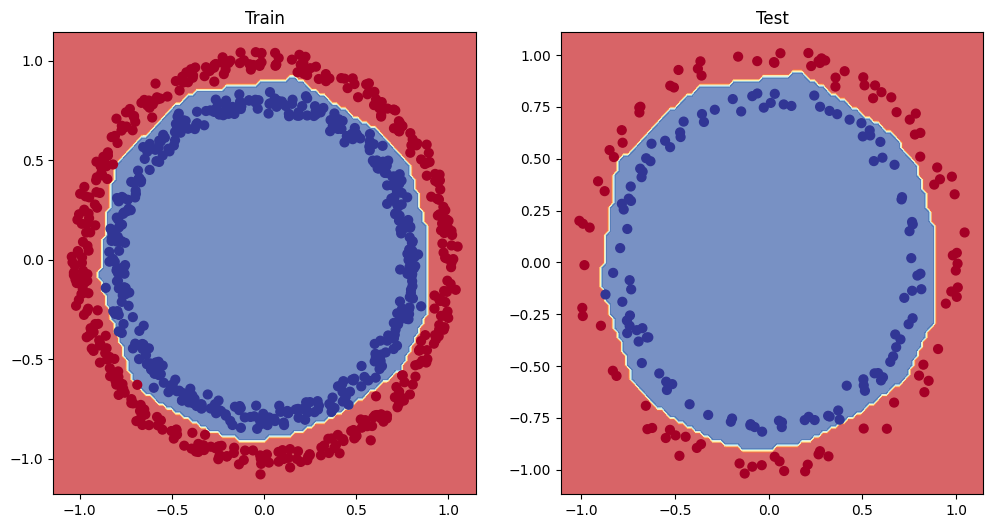

In [29]:
#make predictions
model3.eval()
with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model3(X_test))).squeeze()
y_preds[:10],y_test[:10]
#plot decision boundaries

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

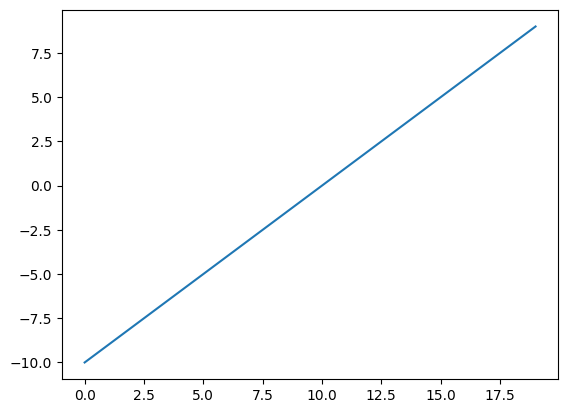

In [30]:
#replicating non-linear activation functions 
A=torch.arange(-10,10,1,dtype=torch.float32)

#visualization of data
plt.plot(A)

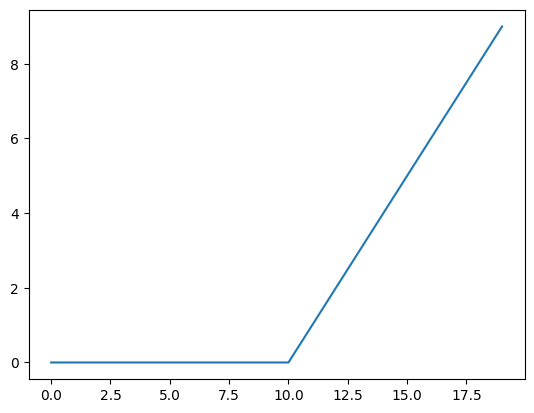

In [31]:
plt.plot(torch.relu(A))

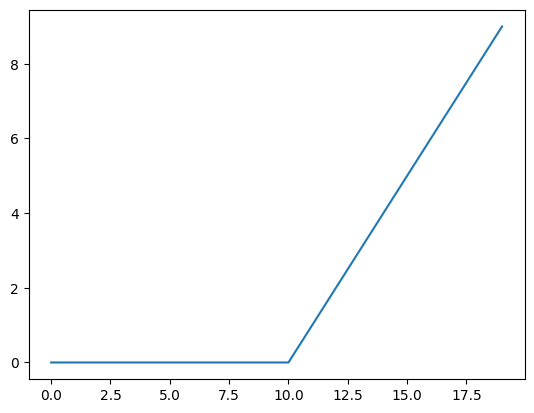

In [33]:
def relu(x: torch.Tensor)-> torch.Tensor:
    return torch.maximum(torch.tensor(0),x)#relu function , inputs must be tensor
plt.plot(relu(A))

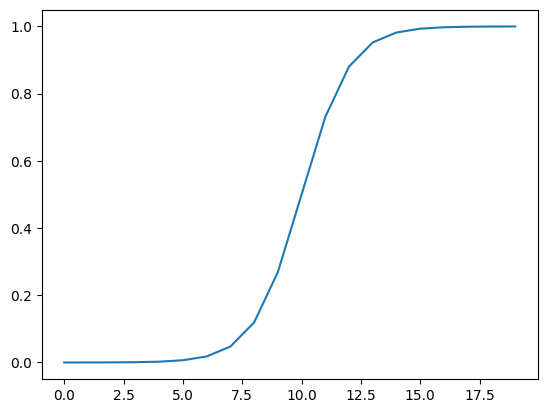

In [35]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))
plt.plot(torch.sigmoid(A))


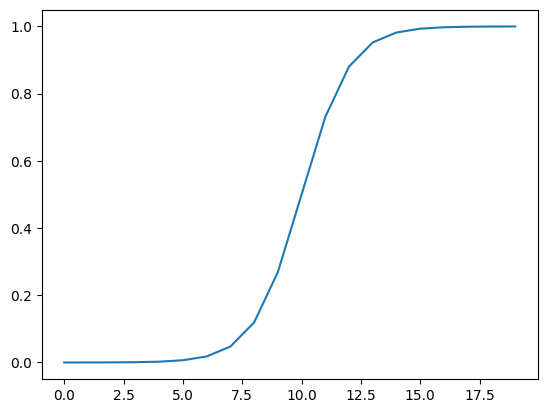

In [36]:
plt.plot(sigmoid(A))

#putting it all together with a multi class classification problem
binary classification : comparision between two things eg:- cat vs dog , spam or not spam , fraud or not fraud 
multi class  classification : more than one thing or another 

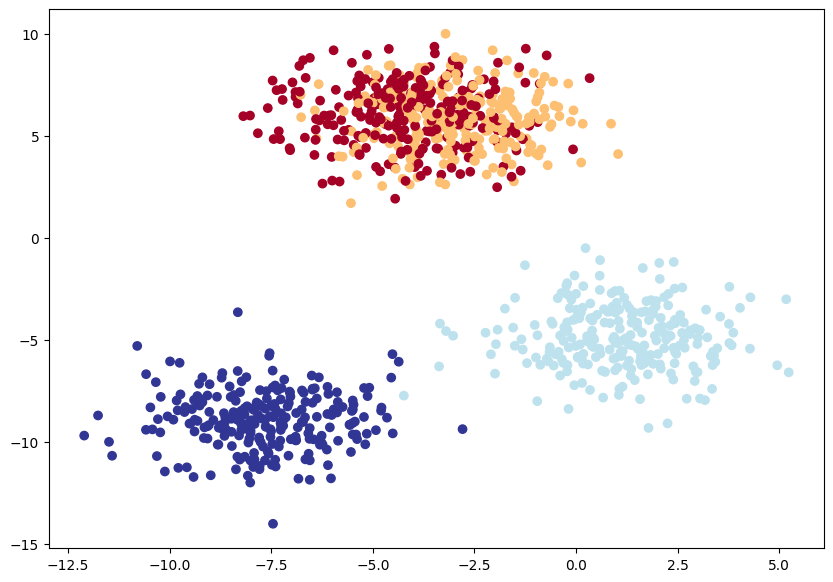

In [61]:
#creting a toy multiset dataset
import torch
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the hyperparamters for data creation 
NUM_CLASSES= 4
NUM_FEATURES = 2
RANDOM_SEED= 69

#create multiclass data \
X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=RANDOM_SEED)#give the clusters a little shakeup 

#turn data into tensors 
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#split into training and test 
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)

#visualization 
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

In [62]:
#building a multiclass clssification model in pytorch 
#create agnostic code 
device="cuda" if torch.cuda.is_available() else "cpu"
#build a multiclass classification model 
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        #initialises multi-class classification model 
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    
    def forward(self,x):
        return self.linear_layer_stack(x)
    
#create instance of blob model and send it to target device 
model4=BlobModel(input_features=2,output_features=4,
                 hidden_units=8).to(device)

model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [63]:
#8.3 create loss function and an optimizer 
loss_fn= nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model4.parameters(),
                          lr=0.1)

#getting raw outputs from our model 
#  
model4.eval()
with torch.inference_mode():
    y_logits=model4(X_blob_test.to(device))

#convert logits by passing them in activation function 
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_probs[:5]

tensor([[0.3827, 0.3418, 0.1298, 0.1457],
        [0.2560, 0.4543, 0.1445, 0.1453],
        [0.2177, 0.3726, 0.1802, 0.2295],
        [0.1975, 0.4640, 0.1674, 0.1711],
        [0.1993, 0.4706, 0.1669, 0.1632]], device='cuda:0')

In [64]:
#convert prediction prob to pred labels, use argmax for this 
y_preds = torch.argmax(y_pred_probs, dim=1)

#create training and testing loop 
torch.manual_seed(69)
torch.cuda.manual_seed(69)

#set number of epochs 
epochs = 100

#to target device
X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

#loop
for epoch in range(epochs):
    model4.train()
    y_logits= model4(X_blob_train)
    y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
    loss= loss_fn(y_logits,y_blob_train)
    acc=accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #testing 
    model4.eval()
    with torch.inference_mode():
        test_logits=model4(X_blob_test)
        test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_loss=loss_fn(test_logits,y_blob_test)
        test_accuracy=accuracy_fn(y_true=y_blob_test,
                                  y_pred=test_preds)
        
    #print
    if epoch%10==0:
        print(f"epoch: {epoch} | loss: {loss:.4f}, Acc: {acc:.2f}% | test loss: {test_loss:.4f}, test accuracy {test_accuracy:.2f}%")

epoch: 0 | loss: 1.6718, Acc: 17.38% | test loss: 1.3770, test accuracy 29.50%
epoch: 10 | loss: 0.8403, Acc: 69.00% | test loss: 0.7703, test accuracy 73.50%
epoch: 20 | loss: 0.4558, Acc: 71.62% | test loss: 0.4502, test accuracy 73.50%
epoch: 30 | loss: 0.3969, Acc: 79.75% | test loss: 0.4016, test accuracy 77.50%
epoch: 40 | loss: 0.3755, Acc: 80.62% | test loss: 0.3856, test accuracy 76.50%
epoch: 50 | loss: 0.3634, Acc: 81.12% | test loss: 0.3785, test accuracy 75.50%
epoch: 60 | loss: 0.3552, Acc: 81.00% | test loss: 0.3753, test accuracy 75.50%
epoch: 70 | loss: 0.3496, Acc: 80.75% | test loss: 0.3742, test accuracy 74.50%
epoch: 80 | loss: 0.3455, Acc: 80.75% | test loss: 0.3743, test accuracy 74.50%
epoch: 90 | loss: 0.3426, Acc: 80.88% | test loss: 0.3749, test accuracy 74.50%


In [ ]:
#make predictions 
model4.eval()
with torch.inference_mode():
    y_logits=model4(X_blob_test)

y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_labels=torch.argmax(y_pred_probs,dim=1)
y_pred_labels[:10],


(tensor([2, 3, 0, 0, 3, 3, 0, 2, 2, 1], device='cuda:0'),
 tensor([2, 3, 0, 0, 3, 3, 0, 2, 2, 1], device='cuda:0'))

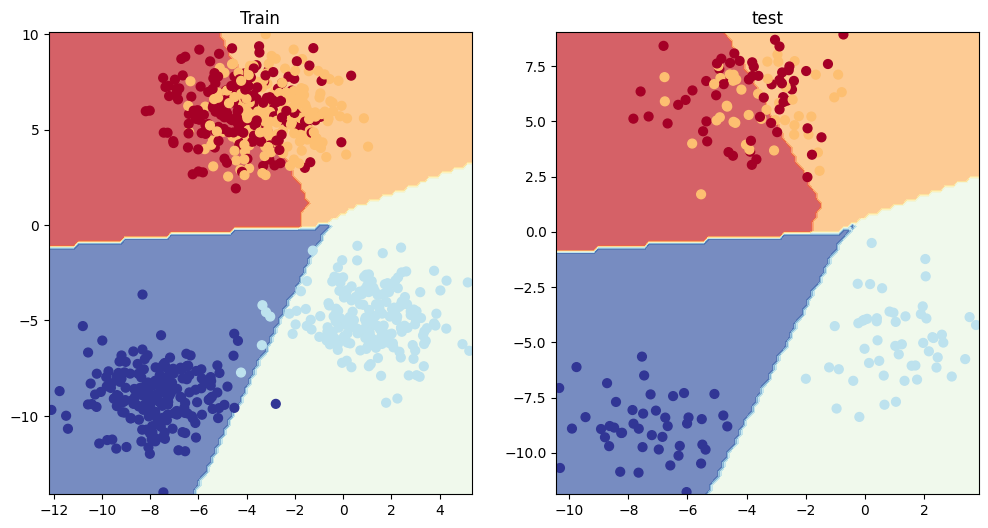

In [69]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model4,X_blob_test,y_blob_test)